Script to analyze the results on real datasets. This includes plotting the trees, gene expression analysis, examining optimized parameters and mutations.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
import seaborn as sns
import os
import json

from src_python.cell_tree import CellTree

In [106]:
study_nums = ["mm16", "mm34"] # cancer sample ids to analyze
np.random.seed(0)
n_rounds = 2 # Number of rounds of parameter and tree optimization
use_summary_statistics = True # If True uses summary files instead of raw data files

primary_cells = {}
cell_names = {}
expression_counts_scaled = {}

for study_num in study_nums: # Primary tumor cells
    if study_num == "mm34":
        cell_indices = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

    if study_num == "mm16":
        cell_indices = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

    ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
    cell_names[study_num] = list(ref[:,0])
    primary_cells[study_num] = [cell_names[study_num].index(item) for item in cell_indices if item in cell_names[study_num]]

    expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
    normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
    expression_counts_scaled[study_num] = np.log1p(normalized_counts)

Plot the trees

In [108]:
def plot_trees(inpath, test, plot_mutations=False, round=0, pc=[], model=""):

    path_parent = os.path.join(inpath, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()
        graph.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in pc:
            graph_branches.node(str(n), shape="circle", style="filled", color="red")
        else:
            graph_branches.node(str(n), shape="circle", style="filled", color="blue") # metastasis

    graph_branches.render(os.path.join(inpath, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format="png", cleanup=True)

for study_num in study_nums:
    path = rf"../data/results/{study_num}/sciterna"
    for j in range(2):
        plot_trees(path, "r0", plot_mutations=True, round=f"_{j}", pc = primary_cells[study_num], model="sciterna")

    model = "sclineager"
    plot_trees(rf"../data/results/{study_num}/sclineager", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="sclineager")
    plot_trees(rf"../data/results/{study_num}/dendro", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="dendro")
    plot_trees(rf"../data/results/{study_num}/phylinsic", "", plot_mutations=False, round = "", pc = primary_cells[study_num], model="phylinsic")

ValueError: could not convert string 'None' to int32 at row 45, column 1.

In [ ]:
def plot_consensus_tree(parent_vector, path, study_num, support_thresholds=None):

    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = "circle"
        node_style = "filled"

        if is_leaf:
            border_color = "red" if node_id in primary_cells[study_num] else "blue"
            fillcolor = "red" if node_id in primary_cells[study_num] else "blue"

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color=border_color,
                penwidth="4"
            )
        else:
            fillcolor = "lightgrey"
            penwidth = 1

            max_support = np.max(list(support_thresholds.values()))
            if support_thresholds:
                support = support_thresholds.get(str(node_id), 0.0)

                penwidth = 20 * support/max_support

            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=fillcolor,
                color="black",
                penwidth=str(penwidth)
            )

    else:
        graph_branches.render(os.path.join(path, f"sciterna_consensus_tree_{study_num}"), format="png", cleanup=True)
    return graph_branches

graphs = {}
consensus_parent_vec = {}
for study_num in study_nums:
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
    consensus_parent_vec[study_num] = np.loadtxt(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec","sciterna_parent_vec_1r.txt"), dtype=int)

    with open(os.path.join(path_bootstrap, "sciterna_consensus_parent_vec", "sciterna_support_values_1r.json"), "r") as f:
        support_values = json.load(f)

    graph = plot_consensus_tree(consensus_parent_vec[study_num], path_bootstrap, study_num, support_thresholds=support_values)
    graphs[study_num] = graph

In [5]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}
for study_num in study_nums:
    positions = get_node_positions(graphs[study_num])
    adj_list = build_adj_list(consensus_parent_vec[study_num])
    root = np.where(np.array(consensus_parent_vec[study_num]) == -1)[0][0]

    leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names[study_num]), positions)

Gene expression analysis

<Figure size 4000x2000 with 0 Axes>

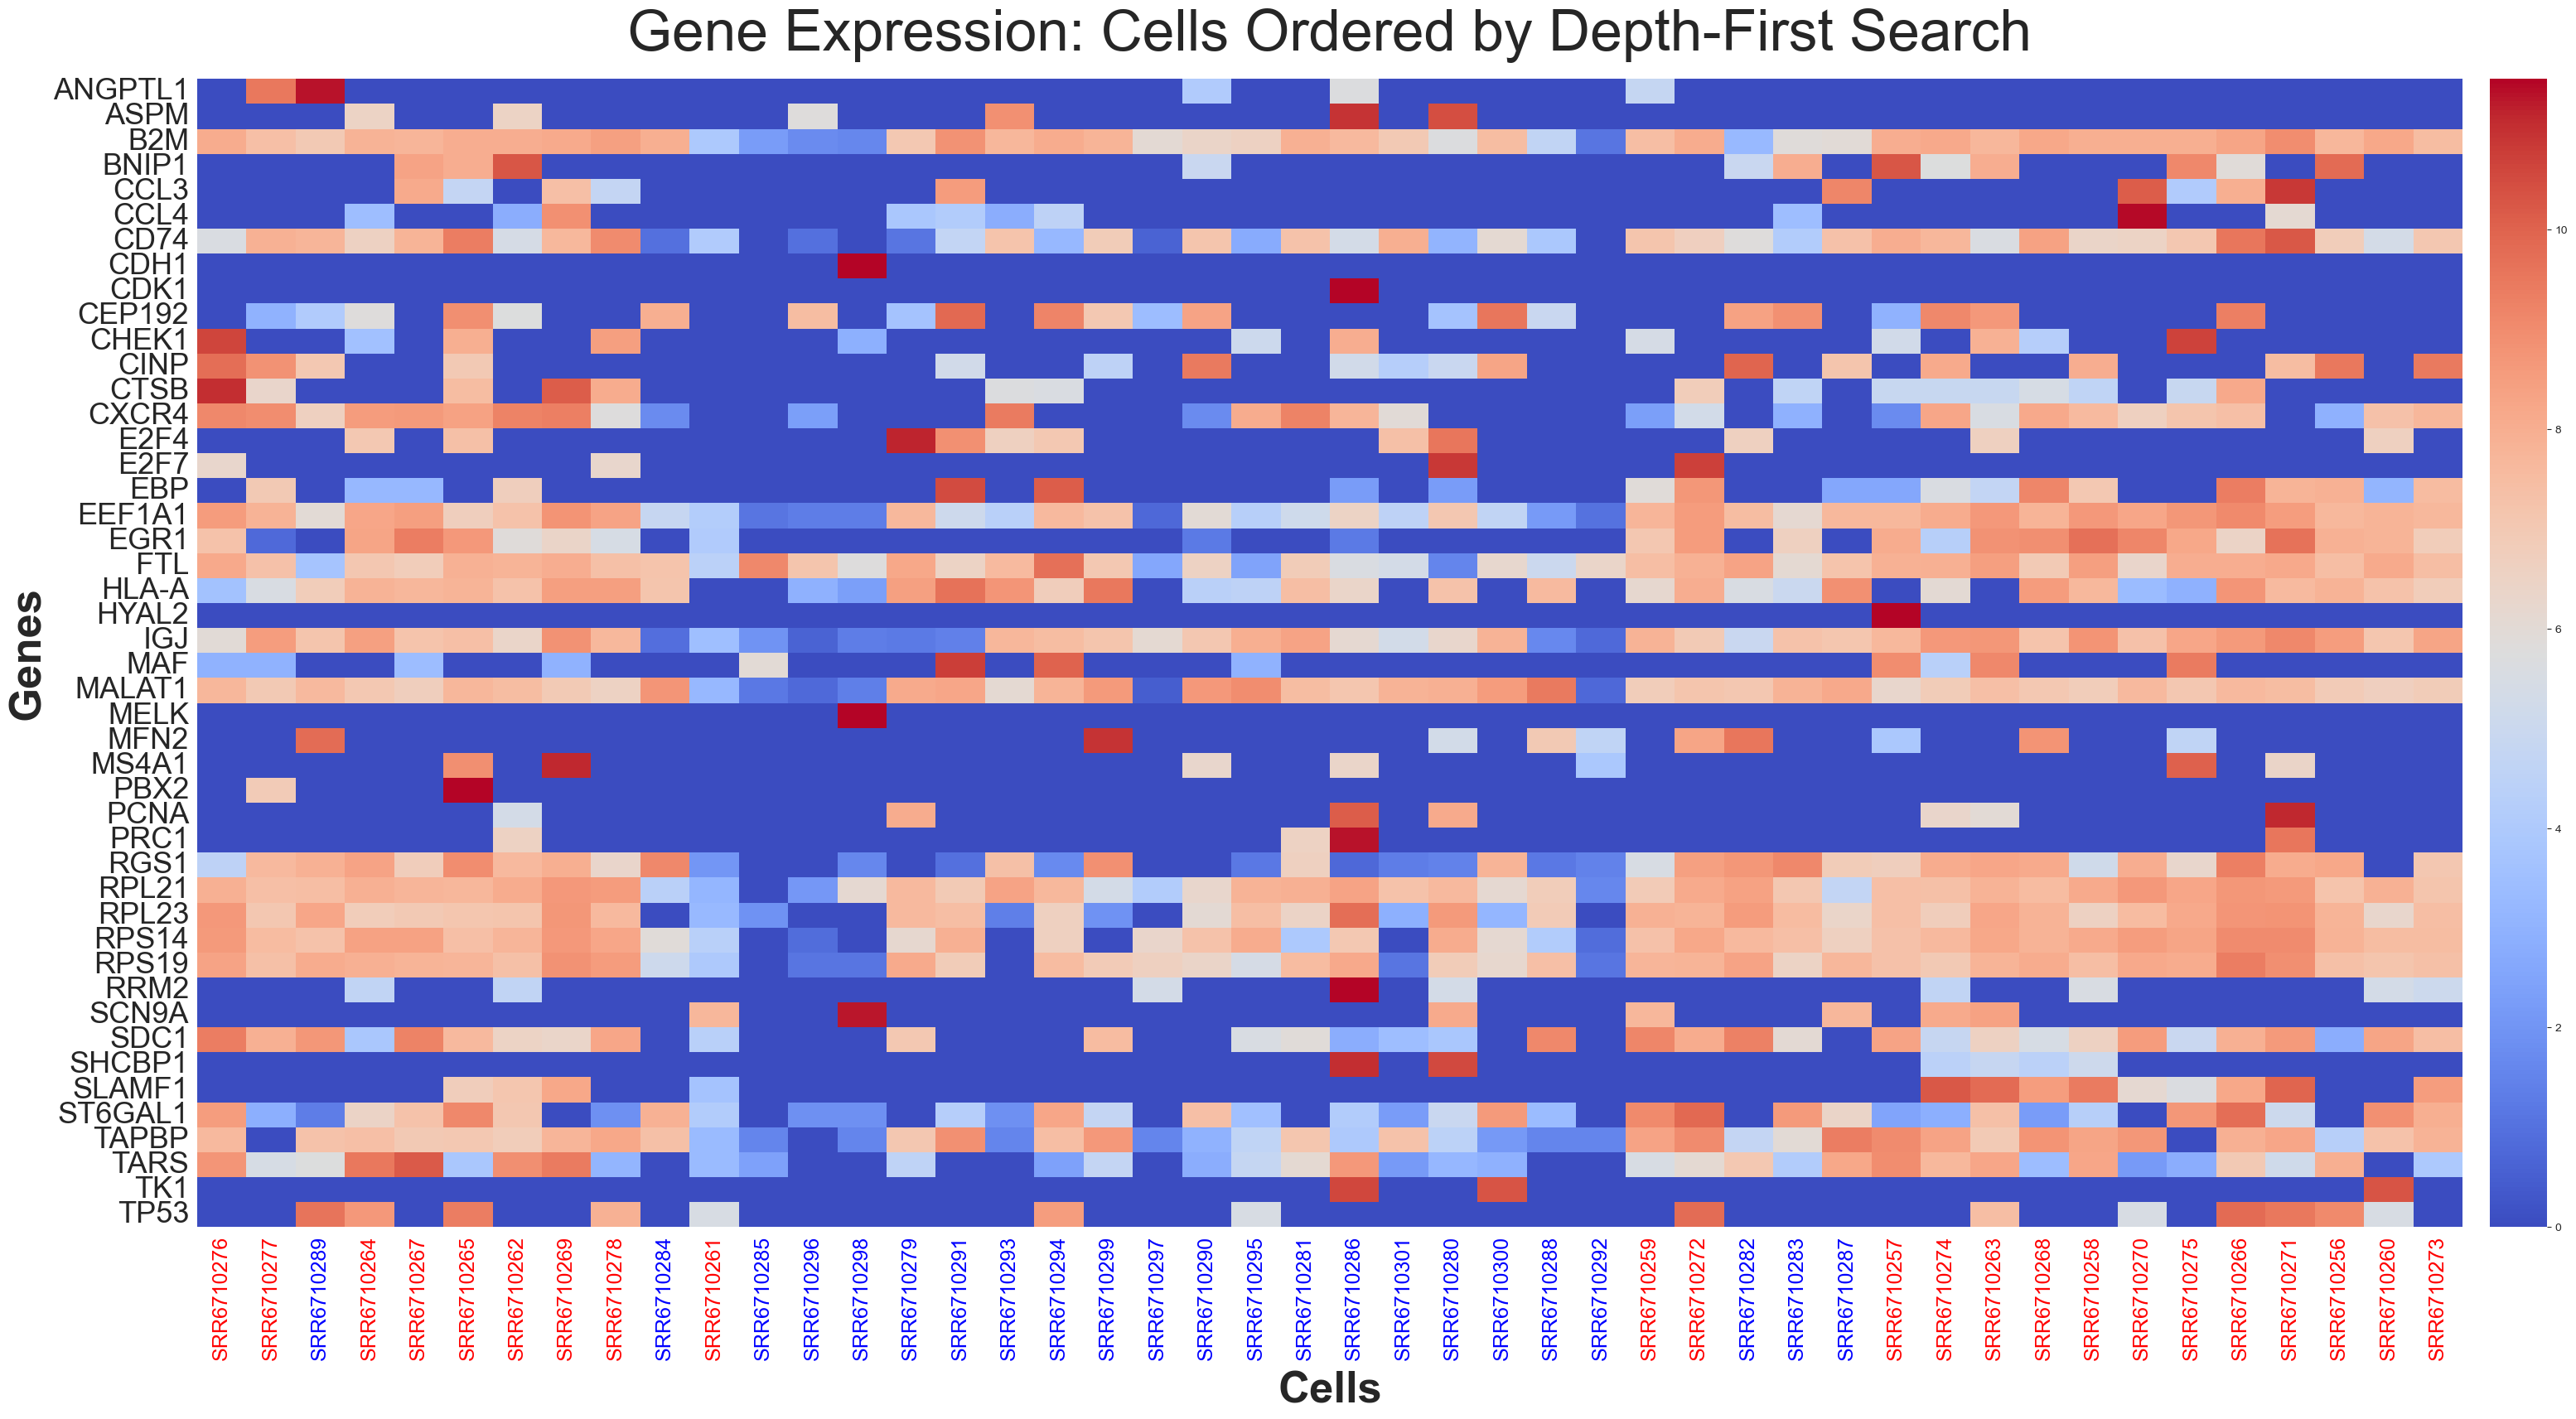

<Figure size 4000x2000 with 0 Axes>

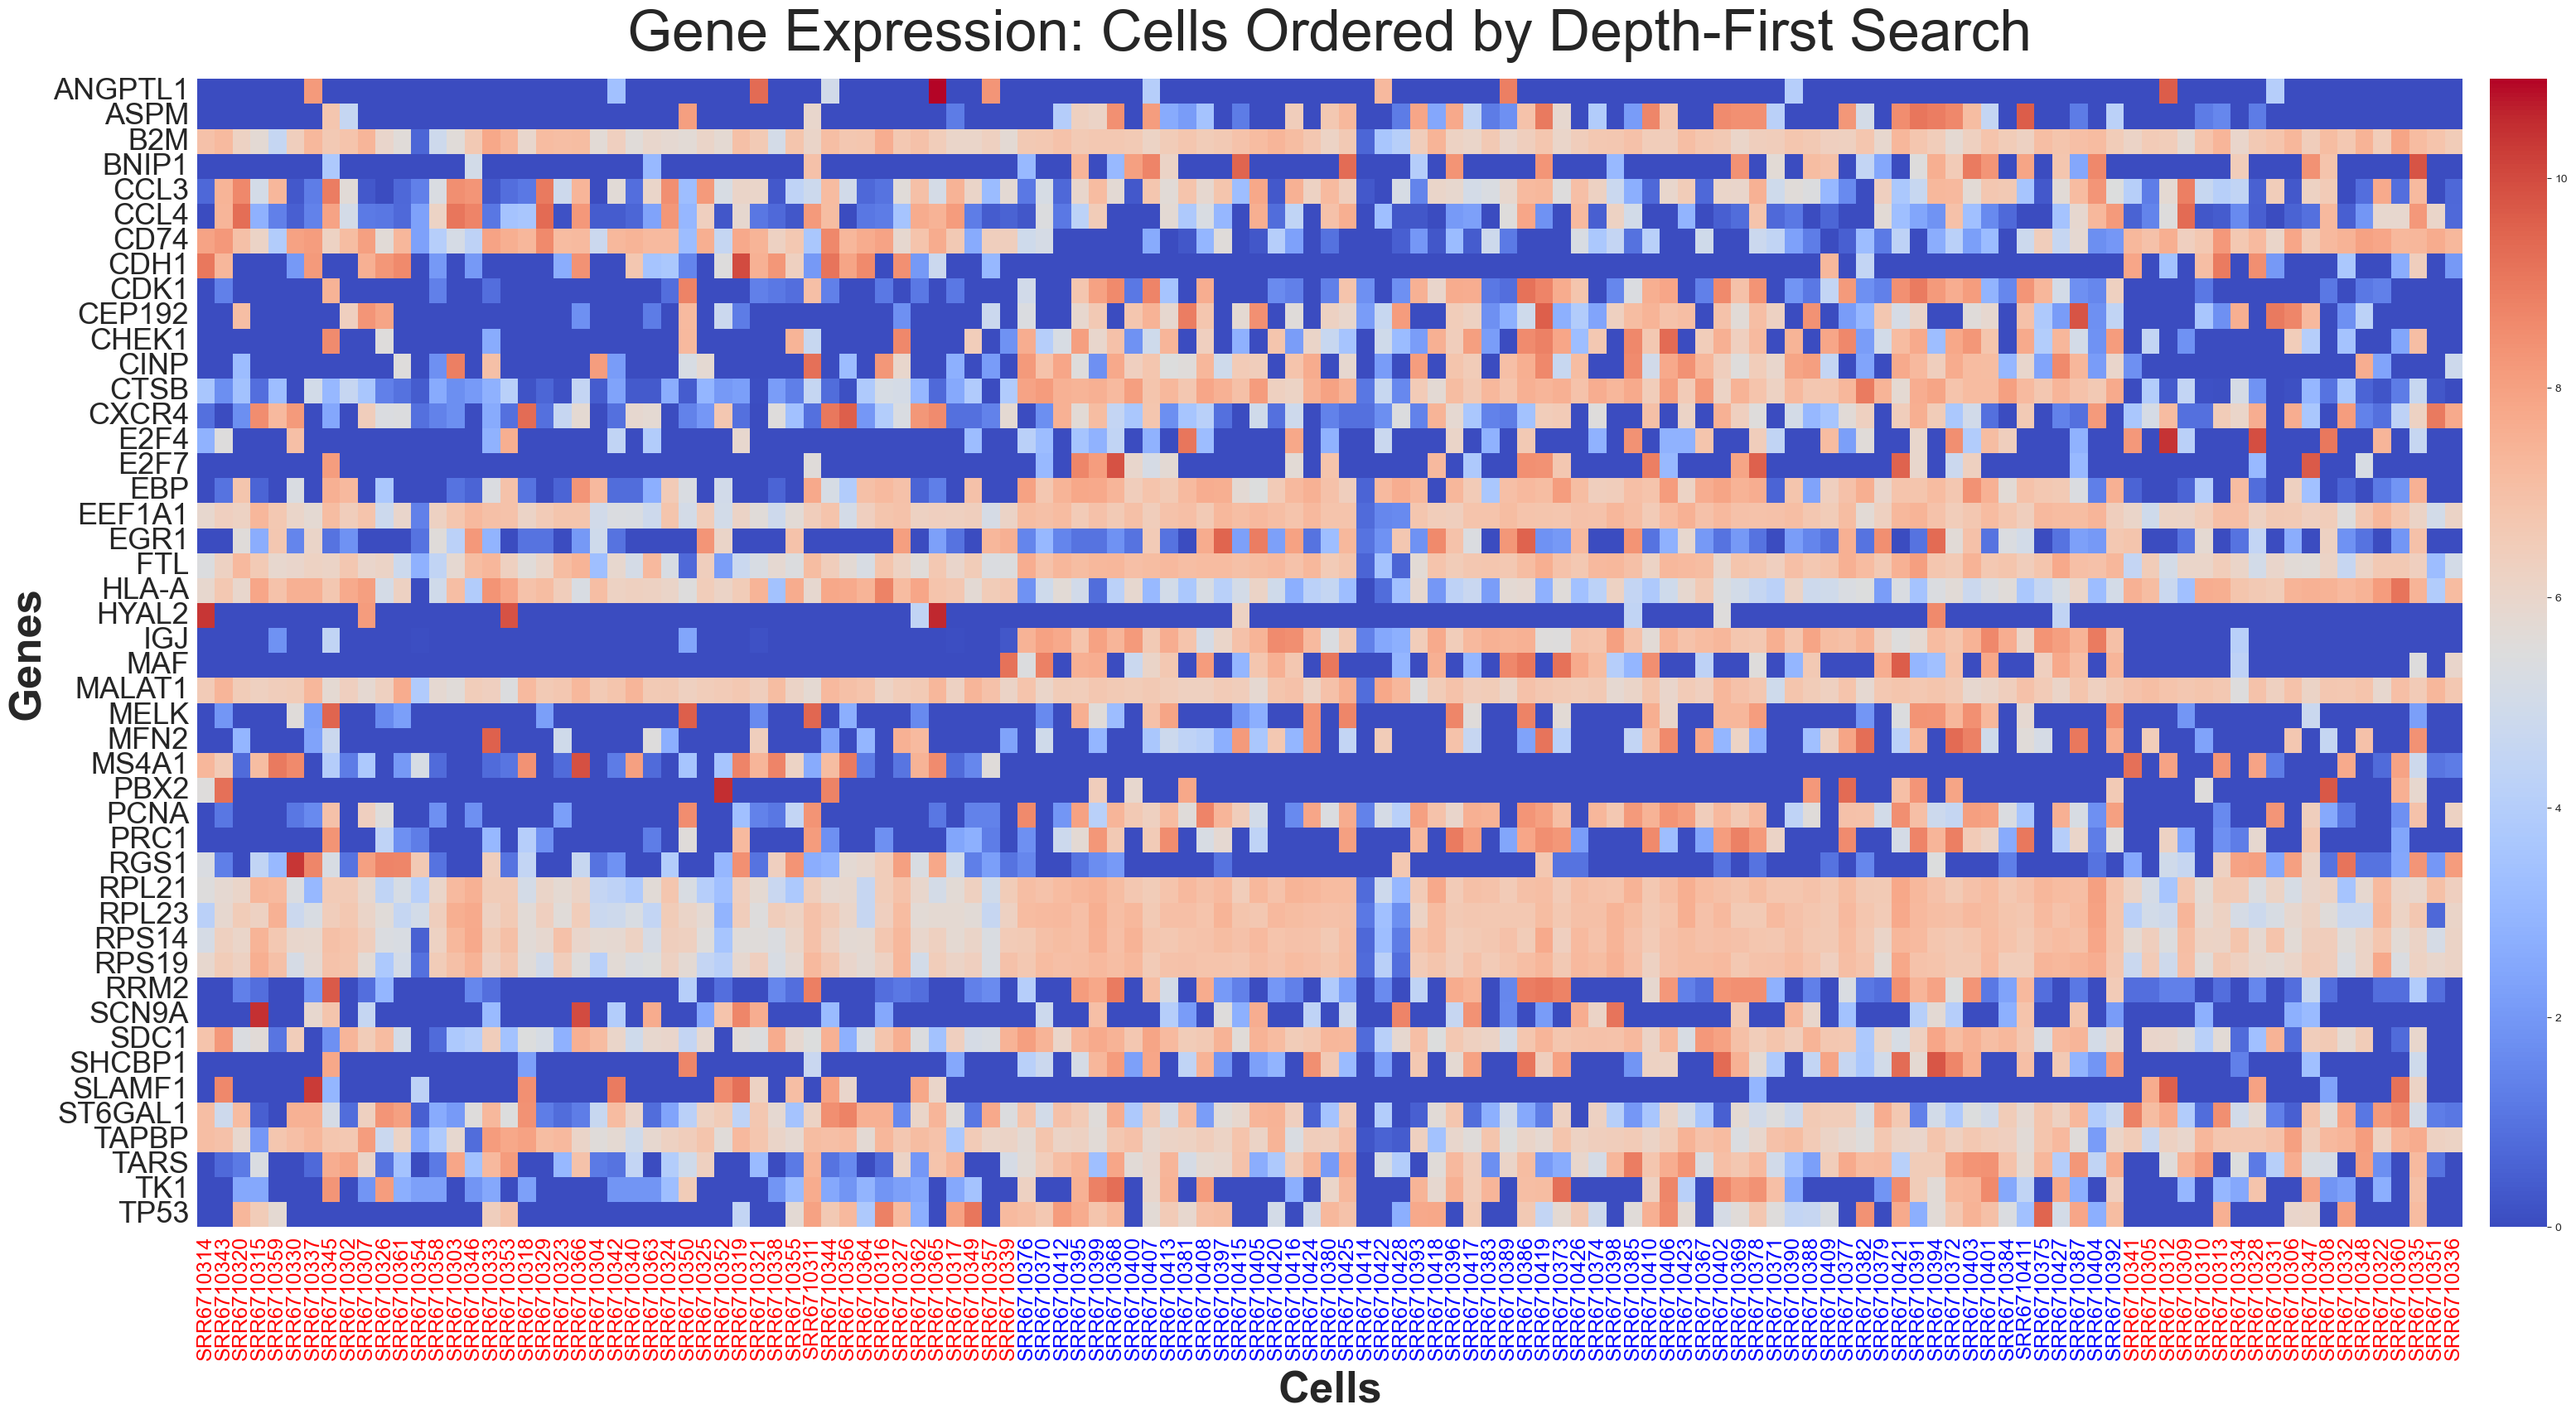

In [6]:
for study_num in study_nums:
    sorted_indices = leaf_orders[study_num]

    plt.figure(figsize=(40, 20))

    genes = ["IGJ", "CTSB", "EGR1", "FTL", "MALAT1", "RPL21", "SDC1", "SLAMF1", "CDH1", "ETV7", "CXCR4", "E2F4", "ANGPTL1", "HYAL2", "PBX2", "SCN9A", "BNIP1", "MFN2", "CEP192", "TARS", "E2F7", "MELK", "CHEK1", "EBP", "CINP", "PCNA", "ASPM", "CDK1", "MAF", "TP53", "MS4A1", "RGS1", "ST6GAL1", "HLA-A", "TAPBP", "CD74", "B2M", "CCL3", "CCL4", "RPS14","RPS19", "RPL23", "EEF1A1", "TK1", "RRM2","SHCBP1", "PRC1"]

    exp = expression_counts_scaled[study_num]
    chosen_genes = exp[exp.index.isin(genes)]
    sorted_df = chosen_genes.iloc[:, sorted_indices]

    col_colors = ["red" if val in primary_cells[study_num] else "blue" for val in sorted_indices]

    plt.figure(figsize=(42, 18))
    ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

    for n, tick_label in enumerate(ax.get_xticklabels()):
        tick_label.set_color(col_colors[n])
        tick_label.set_fontsize(18)

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontsize(26)
        tick_label.set_rotation(0)

    plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
    plt.ylabel("Genes", fontsize=38, fontweight="bold")
    plt.xlabel("Cells", fontsize=38, fontweight="bold", labelpad=10)
    plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.svg", format="svg")
    plt.show()

Estimating the model parameters

In [7]:
n_bootstrap = 1000

global_parameters = {}
mean_individual_overdispersions_h = {}
mean_individual_dropouts = {}

if not use_summary_statistics:
    for study_num in study_nums:
        path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"
        global_parameters[study_num] = []
        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                global_param = np.loadtxt(os.path.join(path_bootstrap, "sciterna_global_parameters", f"sciterna_global_parameters_{j}r{i}.txt")).tolist()
                global_parameters[study_num].append(global_param)
        global_parameters[study_num] = global_parameters[study_num] # Dropout, Overdispersion homozygous, Error Rate, Overdispersion heterozygous

        selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=",", dtype=int)
        ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

        all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
        all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

        for i in range(n_bootstrap):
            for j in range(n_rounds-1, n_rounds):
                selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
                individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
                individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

                unique_mutations = np.unique(selected_mutations)
                for mut in unique_mutations:
                    indices = np.where(selected_mutations == mut)[0]
                    mean_dropout = np.mean(individual_dropouts[indices])
                    mean_overdispersion = np.mean(individual_overdispersions_h[indices])

                    all_individual_dropouts[i, mut] = mean_dropout
                    all_individual_overdispersions_h[i, mut] = mean_overdispersion

        global_parameters_sample = np.array(global_parameters[study_num])

        sufficient_data_columns_od = ~np.any(
            all_individual_overdispersions_h == global_parameters_sample[:, 3][:, np.newaxis], axis=0
        )

        sufficient_data_columns_dropout = ~np.any(
            all_individual_dropouts == global_parameters_sample[:, 0][:, np.newaxis], axis=0
        )
        mean_individual_overdispersions_h[study_num] = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0).tolist()
        mean_individual_dropouts[study_num] = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0).tolist()

else:
    with open("../data_summary/real_data/global_parameters.json", "r") as f:
        global_parameters = json.load(f)
    with open("../data_summary/real_data/mean_individual_overdispersions_h.json", "r") as f:
        mean_individual_overdispersions_h = json.load(f)
    with open("../data_summary/real_data/mean_individual_dropouts.json", "r") as f:
        mean_individual_dropouts = json.load(f)

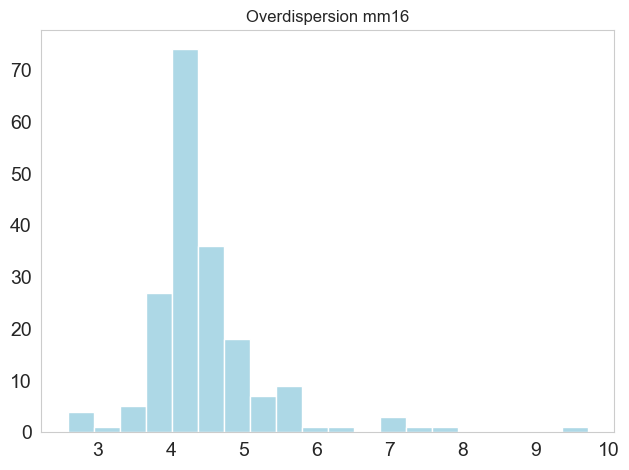

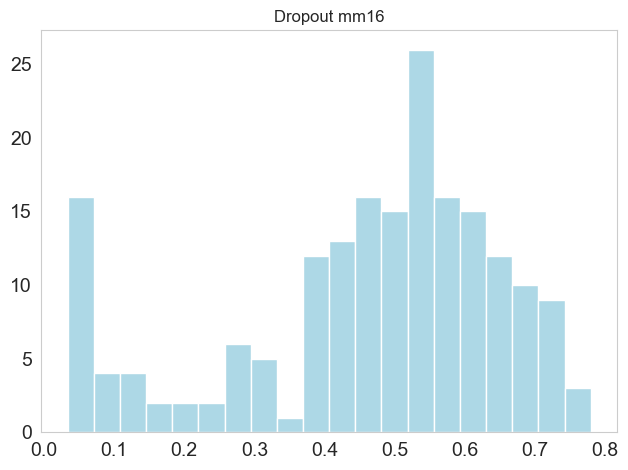

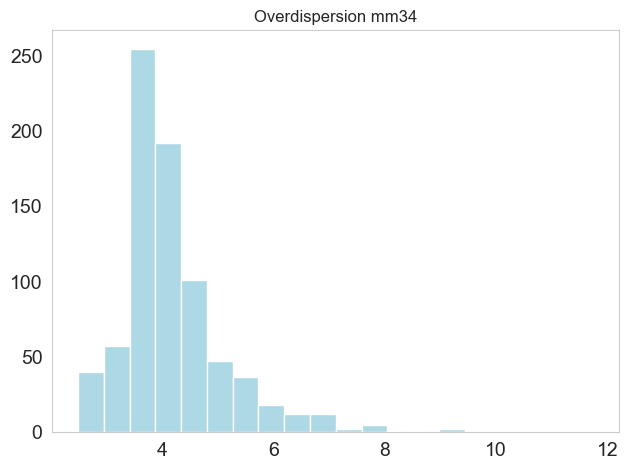

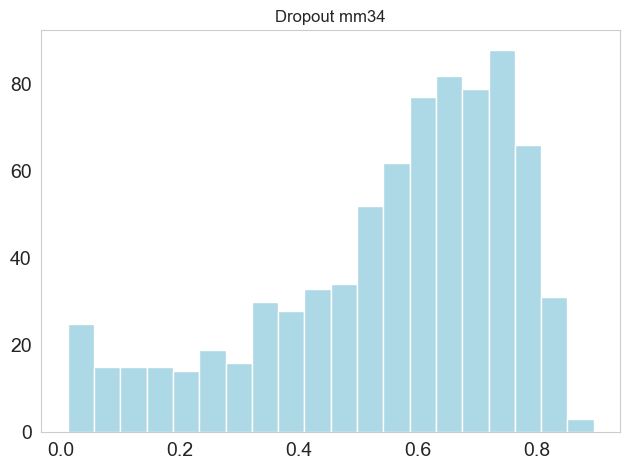

In [8]:
for study_num in study_nums:
    # get the individual parameters, that were optimized for each SNV, instead of using the global parameter value
    mean_dropouts = mean_individual_dropouts[study_num]
    mean_overdispersions = mean_individual_overdispersions_h[study_num]
    path_bootstrap = rf"../data/results/{study_num}/sciterna_bootstrap"

    plt.hist(mean_overdispersions, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Overdispersion {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "overdispersion_histogram.svg"), format="svg")
    plt.show()

    plt.hist(mean_dropouts, bins=20, color="lightblue")
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"Dropout {study_num}")
    plt.tight_layout()
    # plt.savefig(os.path.join(path_bootstrap, "dropout_histogram.svg"), format="svg")
    plt.show()

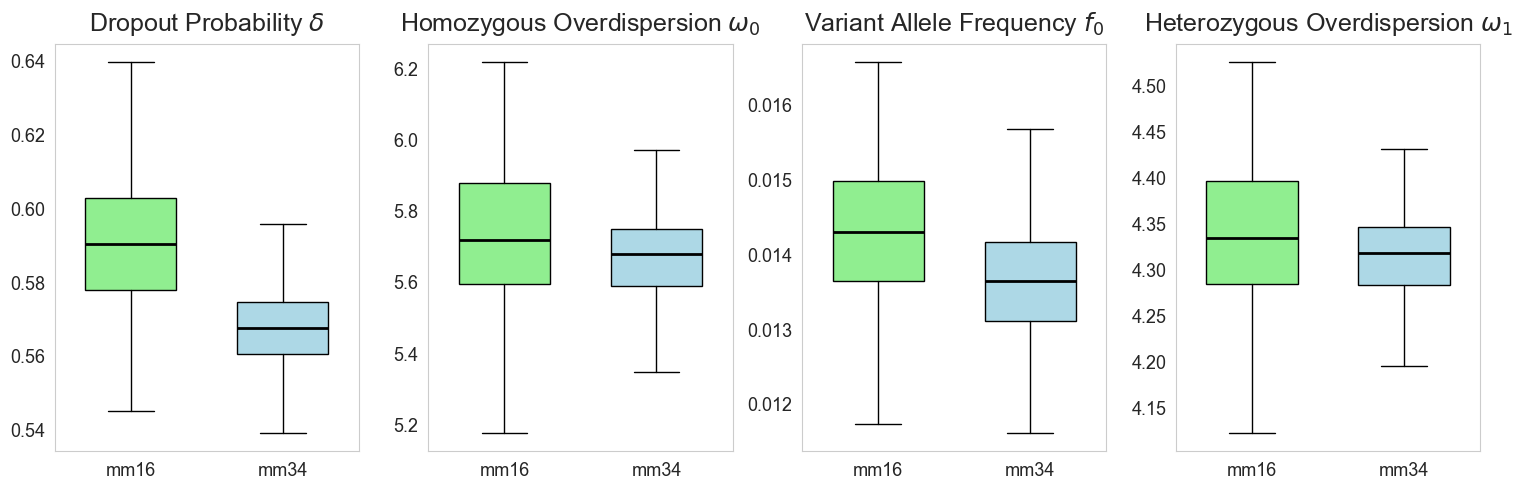

In [9]:
param_names = [r"Dropout Probability $\delta$", r"Homozygous Overdispersion $\omega_\mathrm{0}$", r"Variant Allele Frequency $f_\mathrm{0}$", r"Heterozygous Overdispersion $\omega_\mathrm{1}$"]

for study_num in study_nums:
    global_parameters[study_num] = np.array(global_parameters[study_num])

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
box_colors = ["lightgreen", "lightblue", "lightcoral", "khaki"]

for idx, param_name in enumerate(param_names):
    data = [global_parameters[s][:, idx] for s in study_nums]
    bplot = axes[idx].boxplot(data, patch_artist=True, labels=study_nums, showfliers=False, widths=0.6)

    for patch, color in zip(bplot["boxes"], box_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor("black")

    for median in bplot["medians"]:
        median.set_color("black")
        median.set_linewidth(2)

    axes[idx].set_title(param_name, fontsize=18, pad=10)
    axes[idx].set_ylabel(f"", fontsize=14)
    axes[idx].tick_params(axis="x", labelsize=13)
    axes[idx].tick_params(axis="y", labelsize=13)
    axes[idx].grid(False)

plt.tight_layout()
# plt.savefig(r"..\data\results\figures\global_parameters.pdf", format="pdf")
plt.show()

In [116]:
# mod = "BT_S2"
# alt = np.array(pd.read_csv(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\{mod}\alt.csv", dtype=str))[:,1:].astype(int)
# ref = np.array(pd.read_csv(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\{mod}\ref.csv", dtype=str))[:,1:].astype(int)
#
# np.savetxt(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\{mod}\alt.txt", alt, fmt="%d")
# np.savetxt(rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\{mod}\ref.txt", ref, fmt="%d")

In [99]:
# GLIOBLASTOMA DATASET
study_num = "BT_S2"
path= rf"../data/results/{study_num}"

path_cell_types = rf"..\data\input_data\{study_num}\SraRunTable_BT_S2.csv"
cell_types = pd.read_csv(path_cell_types) #["cell_type"] ["Run"]
cell_names = pd.read_csv(rf"..\data\input_data\{study_num}/ref.csv")["Cell"]

run_names = cell_types["Run"].astype(str).tolist()

run_to_type = {}
df_map = cell_types.set_index(cell_types["Run"].astype(str))["cell_type"].to_dict()
for i, run in enumerate(run_names):
    run_to_type[str(run)] = df_map.get(str(run), "unknown")

unique_types = sorted(set(run_to_type.values()))
colors = ["orange", "red", "blue", "green", "purple", "brown", "pink", "gray", "olive", "cyan"]
type_to_color = {t: colors[i] for i, t in enumerate(unique_types)}

In [100]:
def plot_trees(inpath, test, round="", model="", plot_mutations=False, cell_names=None):

    path_parent = os.path.join(inpath, model, f"{model}_parent_vec", f"{model}_parent_vec{round}{test}.txt")
    path_mut_loc = os.path.join(inpath, model, f"{model}_mutation_location", f"{model}_mutation_location{round}{test}.txt")
    path_selected = os.path.join(inpath, model, f"{model}_selected_loci", f"{model}_selected_loci{round}{test}.txt")

    parent_vec = np.loadtxt(path_parent, dtype=int)
    if os.path.exists(path_mut_loc) == False:
        mut_locs = []
        selected_mutations = []
    else:
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
    ct.use_parent_vec(parent_vec)

    if plot_mutations:
        ct.mut_loc = mut_locs
        graph = ct.to_graphviz()

        for n, run_name in enumerate(cell_names):
            ctype = run_to_type.get(run_name, "unknown")
            fillcolor = type_to_color.get(ctype, "#c0c0c0")
            graph.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
            graph.node(str(n), label=run_name)

        graph.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree{round}{test}"), format="png", cleanup=True)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n, run_name in enumerate(cell_names):
        ctype = run_to_type.get(run_name, "unknown")
        fillcolor = type_to_color.get(ctype, "#c0c0c0")
        graph_branches.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
        graph_branches.node(str(n), label=run_name)


    with graph_branches.subgraph(name="cluster_legend") as c:
        c.attr(label="Legend", fontsize="10")
        c.attr(rank="same")
        for i, t in enumerate(unique_types):
            node_name = f"legend_{i}"
            c.node(node_name, label=t, shape="box", style="filled", fillcolor=type_to_color[t], color="black")

    graph_branches.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree{round}{test}_branches"), format="png", cleanup=True)
    return graph_branches, parent_vec

# graph, parent_vector = plot_trees(path, test="0", round="_0r", model="sciterna", cell_names=cell_names, plot_mutations=True)
g, p = plot_trees(path, test="", round="", model="sclineager", cell_names=cell_names, plot_mutations=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.299872 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.299946 to fit


In [98]:
def plot_trees(inpath, model="", cell_names=None):
    path_parent = os.path.join(inpath, model, f"{model}_parent_vec_clustering", f"{model}_parent_vec_clustering.txt")
    parent_vec = np.loadtxt(path_parent, dtype=int)

    n_cells = int(((len(parent_vec)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=3)
    ct.use_parent_vec(parent_vec)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n, run_name in enumerate(cell_names):
        ctype = run_to_type.get(run_name, "unknown")
        fillcolor = type_to_color.get(ctype, "#c0c0c0")
        graph_branches.node(str(n), shape="circle", style="filled", fillcolor=fillcolor, color="black")
        graph_branches.node(str(n), label=run_name)


    with graph_branches.subgraph(name="cluster_legend") as c:
        c.attr(label="Legend", fontsize="10")
        c.attr(rank="same")
        for i, t in enumerate(unique_types):
            node_name = f"legend_{i}"
            c.node(node_name, label=t, shape="box", style="filled", fillcolor=type_to_color[t], color="black")

    graph_branches.render(os.path.join(inpath, model, f"{model}_ct_trees", f"ct_tree_clustering"), format="png", cleanup=True)
    return graph_branches, parent_vec

g, p = plot_trees(path, model="sciterna", cell_names=cell_names)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.332339 to fit


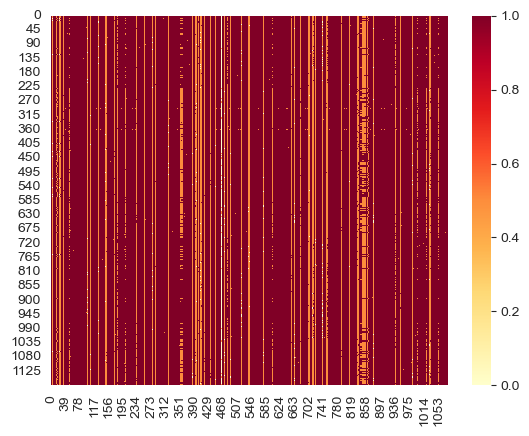

C:\Users\Norio\AppData\Local\Temp\ipykernel_17092\3248908991.py:14: RuntimeWarning: invalid value encountered in divide
  vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))
C:\Users\Norio\AppData\Local\Temp\ipykernel_17092\3248908991.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd").copy() if hasattr(plt.cm.get_cmap("YlOrRd"), "copy") else plt.cm.get_cmap("YlGnBu")


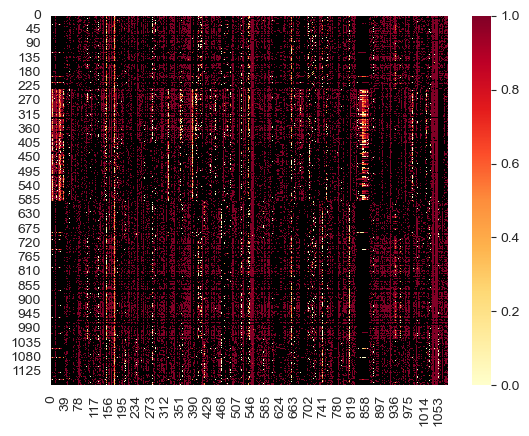

In [44]:
def plot_genotypes(model="sciterna"):
    genotype_predicted = np.loadtxt(os.path.join(path, model, f"{model}_genotype", f"{model}_genotype_1r0.txt"), dtype=str)
    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_predicted = vectorized_map(genotype_predicted)

    alt = np.array(pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\alt.csv", dtype=str))[1:,1:].astype(int)
    ref = np.array(pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\ref.csv", dtype=str))[1:,1:].astype(int)


    sns.heatmap(genotype_predicted, cmap="YlOrRd")
    plt.show()

    vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))

    cmap = plt.cm.get_cmap("YlOrRd").copy() if hasattr(plt.cm.get_cmap("YlOrRd"), "copy") else plt.cm.get_cmap("YlGnBu")
    cmap.set_bad("black")

    sns.heatmap(vaf, cmap=cmap, vmin=0.0, vmax=1.0)
    plt.show()
plot_genotypes()

C:\Users\Norio\AppData\Local\Temp\ipykernel_17092\363464558.py:25: RuntimeWarning: invalid value encountered in divide
  vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))
C:\Users\Norio\AppData\Local\Temp\ipykernel_17092\363464558.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("YlOrRd").copy()
C:\Users\Norio\AppData\Local\Temp\ipykernel_17092\363464558.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


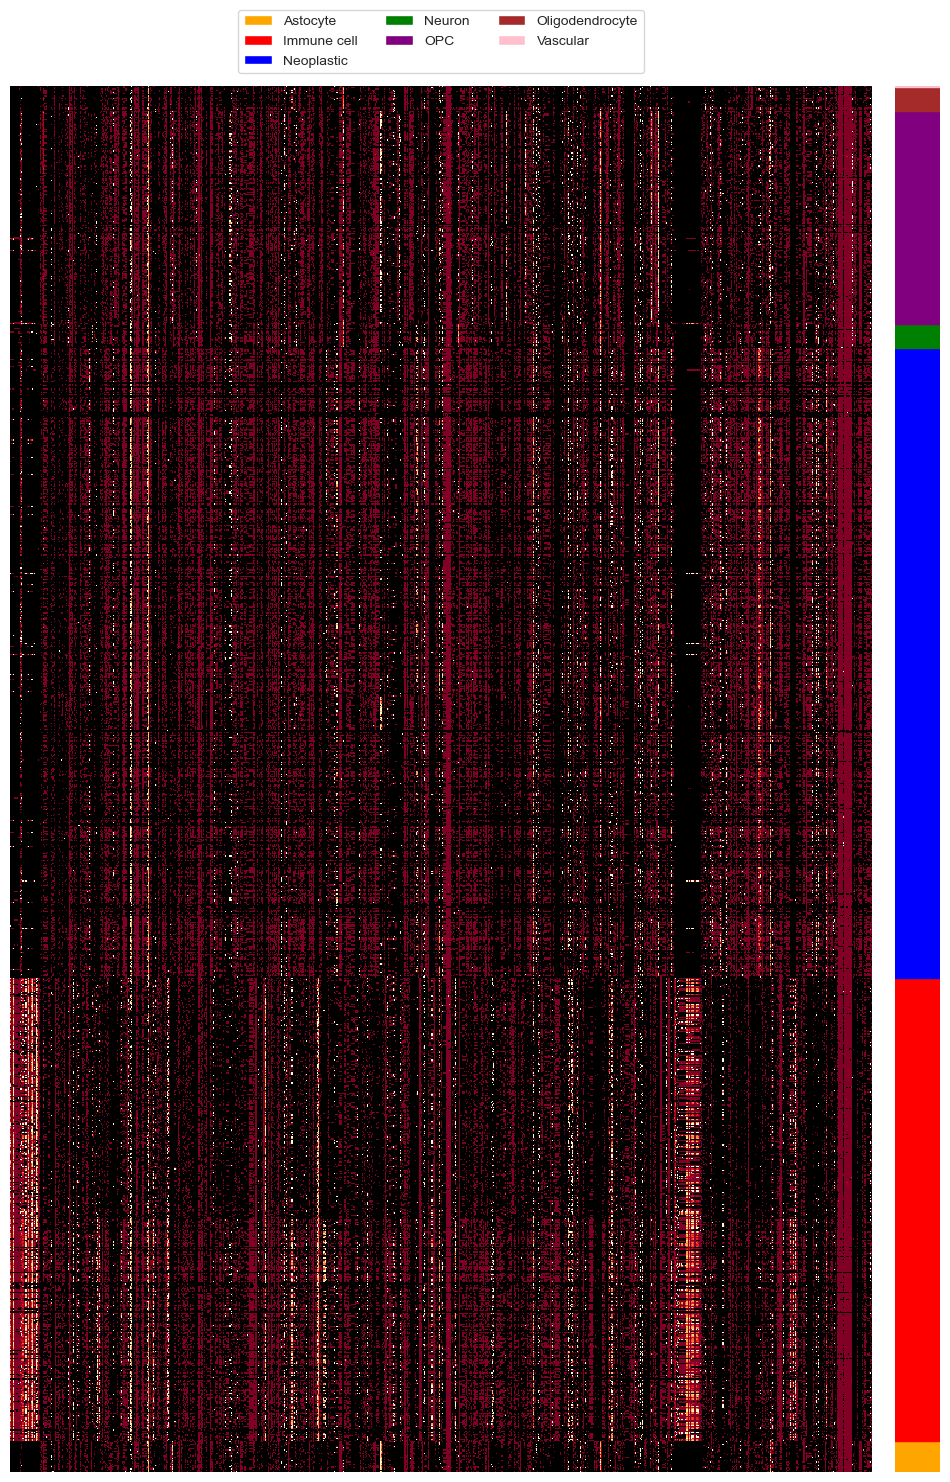

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

def plot_genotypes(model="sciterna", run_to_type=None, type_to_color=None):

    # Load ref and alt data as DataFrames to preserve row (cell) and column (mutation) names
    alt_df = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\alt.csv", index_col=0)
    ref_df = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\BT_S2\ref.csv", index_col=0)

    genotype_predicted = np.loadtxt(os.path.join(path, model, f"{model}_genotype", f"{model}_genotype_1r0.txt"), dtype=str)
    mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
    vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
    genotype_predicted = vectorized_map(genotype_predicted)

    # Extract row names (cell names)
    cell_names = alt_df.index

    # Calculate VAF
    alt = alt_df.values.astype(int)
    ref = ref_df.values.astype(int)
    vaf = np.where((ref + alt) == 0, np.nan, alt / (ref + alt))

    # Order rows (cells) by cell type
    if run_to_type is None or type_to_color is None:
        raise ValueError("run_to_type and type_to_color must be provided as dictionaries.")

    # Map cell names to types
    cell_types = [run_to_type.get(cell, "unknown") for cell in cell_names]

    # Get unique types and their order
    unique_types = sorted(
        set(cell_types),
        key=lambda x: list(type_to_color.keys()).index(x) if x in type_to_color else len(type_to_color)
    )

    # Order cell names by type
    ordered_cell_names = sorted(
        cell_names,
        key=lambda x: unique_types.index(run_to_type.get(x, "unknown"))
    )

    # Reorder VAF matrix to match ordered_cell_names
    row_indices = [list(cell_names).index(name) for name in ordered_cell_names][::-1]
    vaf_ordered = vaf[row_indices, :] #genotype_predicted[row_indices, :]

    # Create a list of colors for each cell (row)
    row_colors = [type_to_color[run_to_type.get(cell, "unknown")] for cell in ordered_cell_names]

    # Plot VAF heatmap
    cmap = plt.cm.get_cmap("YlOrRd").copy()
    cmap.set_bad("black")

    fig = plt.figure(figsize=(12, 18))
    gs = fig.add_gridspec(1, 2, width_ratios=[0.95, 0.05], wspace=0.05)

    # Main heatmap axis
    ax = fig.add_subplot(gs[0, 0])

    # Color bar axis
    cbar_ax = fig.add_subplot(gs[0, 1])

    # Plot heatmap
    sns.heatmap(
        vaf_ordered,
        cmap=cmap,
        vmin=0.0,
        vmax=1.0,
        yticklabels=False,  # Hide row names
        xticklabels=False,  # Hide column names (mutations)
        ax=ax,
        cbar=False
    )

    # Add a color bar for cell types
    for i, color in enumerate(row_colors):
        cbar_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))

    cbar_ax.set_xlim(0, 1)
    cbar_ax.set_ylim(0, len(row_colors))
    cbar_ax.axis('off')

    # Create a legend for cell types
    legend_elements = [Patch(facecolor=type_to_color[t], label=t) for t in unique_types]
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.06),
        ncol=3,
        fontsize=10
    )

    plt.tight_layout()
    # plt.savefig(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\BT_S2\sciterna\vaf.pdf")
    plt.show()

    return row_colors, ordered_cell_names

rcs, ocns = plot_genotypes(
    model="sciterna",
    run_to_type=run_to_type,
    type_to_color=type_to_color
)

In [16]:
def get_node_positions(dot):
    """Get x-coordinates of all nodes from Graphviz layout."""
    A = pgv.AGraph(string=dot.source if hasattr(dot, 'source') else dot)
    A.layout(prog="dot")
    positions = {}
    for node in A.nodes():
        name = node.get_name()
        if not name.isdigit():
            continue
        pos = node.attr.get('pos')
        if pos:
            x = float(pos.split(',')[0])
            positions[int(name)] = x
    return positions

def dfs_left_to_right(graph, root, n_cells, positions):

    leaf_order = []

    def dfs(node):
        children = graph.get(node, [])
        # Sort children by x-position
        children_sorted = sorted(children, key=lambda x: positions.get(x, float("inf")))
        if not children:
            if node < n_cells:  # leaf node condition
                leaf_order.append(node)
            return
        for child in children_sorted:
            dfs(child)

    dfs(root)
    return leaf_order

# Build adjacency list from parent vector
def build_adj_list(parent_vec):
    from collections import defaultdict
    adj = defaultdict(list)
    for child, parent in enumerate(parent_vec):
        if parent != -1:
            adj[parent].append(child)
    return adj

leaf_orders = {}

positions = get_node_positions(graph)
adj_list = build_adj_list(parent_vector)
root = np.where(np.array(parent_vector) == -1)[0][0]

leaf_orders[study_num] = dfs_left_to_right(adj_list, root, len(cell_names), positions)

<Figure size 4000x2000 with 0 Axes>

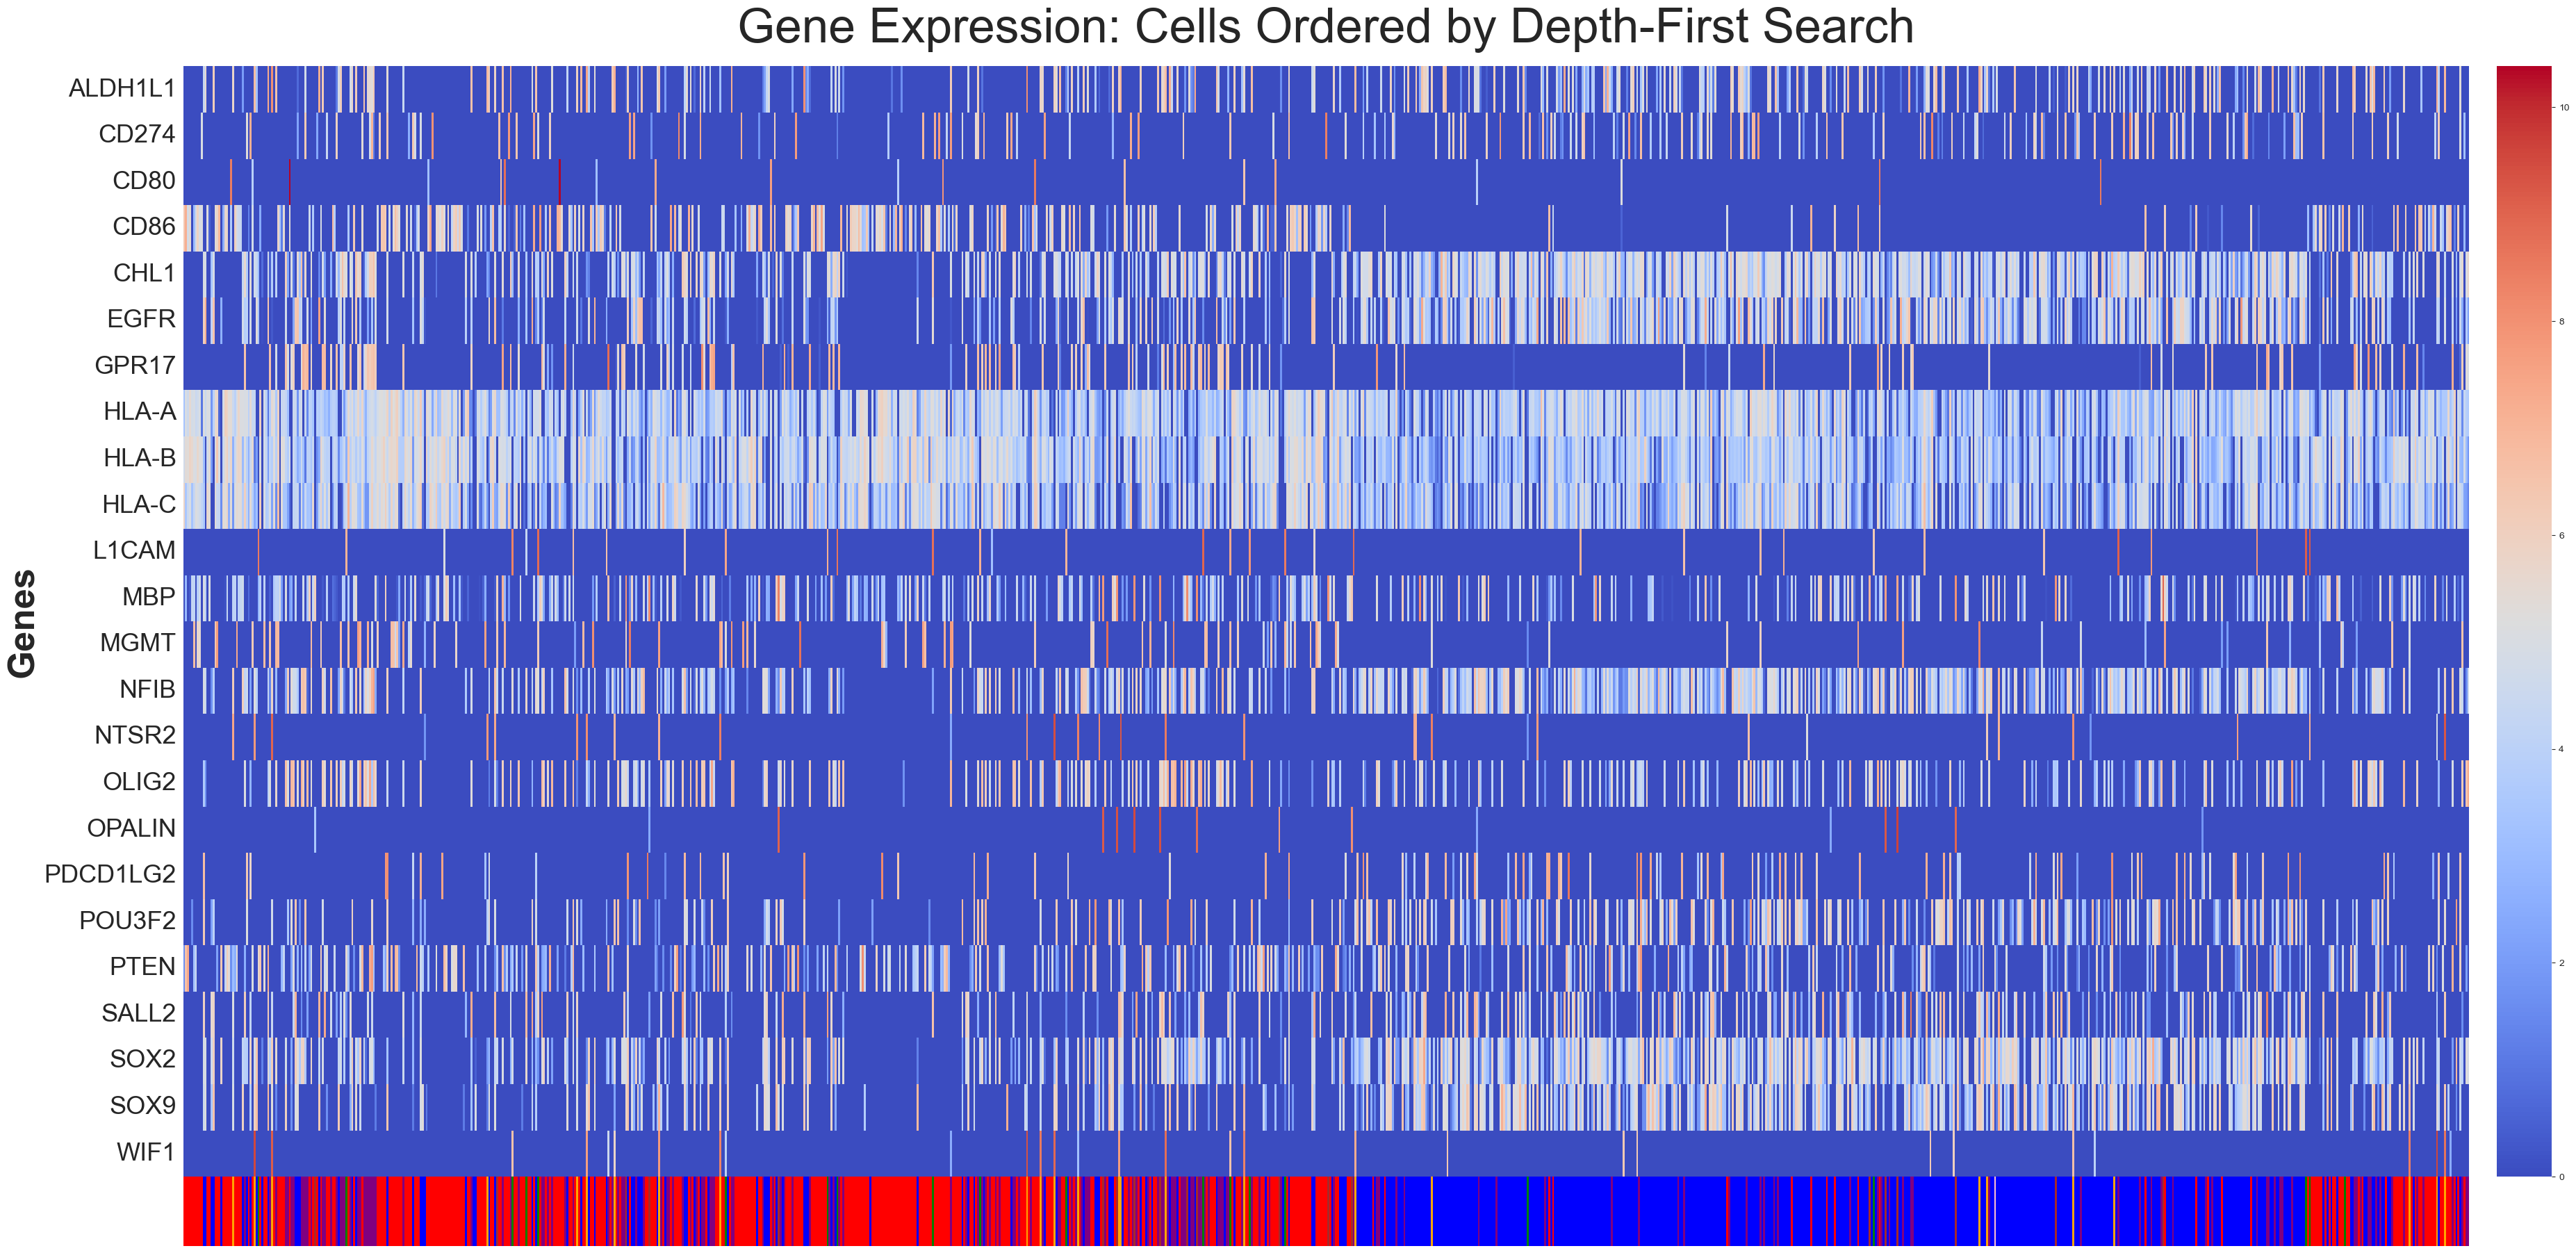

In [42]:
expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled[study_num] = np.log1p(normalized_counts)

sorted_indices = leaf_orders[study_num]

plt.figure(figsize=(40, 20))

genes = [
    "EGFR", "CHL1", "SOX2", "SOX9", "POU3F2", "OLIG2", "SALL2", "NFIB",
    "MBP", "OPALIN", "GPR17", "L1CAM", "ALDH1L1", "WIF1", "NTSR2",
    "HLA-A", "HLA-B", "HLA-C", "CD274", "PDCD1LG2", "CD80", "CD86", "PTEN", "MGMT"
]

exp = expression_counts_scaled[study_num]
chosen_genes = exp[exp.index.isin(genes)]
sorted_df = chosen_genes.iloc[:, sorted_indices]

cells = sorted_df.columns.tolist()

col_colors = [type_to_color[run_to_type[cell]] for cell in cells]

plt.figure(figsize=(42, 18))
ax = sns.heatmap(sorted_df, cmap="coolwarm", cbar_kws={"pad": 0.01})

ax.set_xticklabels([])
ax.set_xlabel("Cells", fontsize=38, fontweight="bold", labelpad=10)

n_genes = sorted_df.shape[0]
from matplotlib.patches import Rectangle

n_cells = len(cells)
for i, color in enumerate(col_colors):
    ax.add_patch(
        Rectangle(
            (i, n_genes - 0.0),
            1, 1.5,         # width 1 cell, height
            color=color,
            transform=ax.transData,
            clip_on=False,
            linewidth=0
        )
    )

for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)
    tick_label.set_rotation(0)

plt.title("Gene Expression: Cells Ordered by Depth-First Search", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=38, fontweight="bold")
plt.tight_layout()
plt.savefig(rf"../data/results/figures/gene_expression_{study_num}.pdf", format="pdf")
plt.show()